# In this notebook, I begin where I left off from from the azure notebook. We will begin by reading in the data prepared in azure and migrated to S3. Then, we will start the analysis from TF-IDF of Determining the most important words in economics subreddits comments body using TF-IDF.

# Setup - AWS

In [2]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.4.0

# install spark-nlp
%pip install spark-nlp==5.1.3

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.11.17         |  py310h06a4308_0         158 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/linux-64::openjdk-11.0.13-h87a67e3_0 



In [3]:
import json
import sparknlp
import numpy as np
import pandas as pd
from sparknlp.base import *
from pyspark.ml import Pipeline
from sparknlp.annotator import *
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from sparknlp.pretrained import PretrainedPipeline

In [4]:
# Import pyspark and build Spark session
spark = SparkSession.builder \
    .appName("Spark NLP")\
    .master("local[*]")\
    .config("spark.driver.memory","16G")\
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3")\
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")\
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )\
    .getOrCreate()

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-28d7e10d-b633-4094-85c0-9f98d6cc0e0a;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 406ms :: artifacts dl 34ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

In [5]:
print(f"Spark version: {spark.version}")
print(f"sparknlp version: {sparknlp.version()}")

Spark version: 3.4.0
sparknlp version: 5.1.3


# Read in NLP Cleaned Data

In [6]:
import sagemaker
sess = sagemaker.Session()
bucket = sess.default_bucket()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


## Comments

In [7]:
# S3 directory path
s3_directory_comms = f"s3a://{bucket}/project/nlp_cleaned_comments/"

# Read all the Parquet files in the directory into a DataFrame
comments_cleaned = spark.read.parquet(s3_directory_comms)

23/12/05 22:53:41 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


## Submissions

In [8]:
# S3 directory path
s3_directory_subs = f"s3a://{bucket}/project/nlp_cleaned_submissions/"

# Read all the Parquet files in the directory into a DataFrame
submissions_cleaned= spark.read.parquet(s3_directory_subs)

# TF-IDF (continue from azure), Common Words, and Text Length

## Determine the most important words in economics subreddits comments body using TF-IDF

### Processing Job

In [9]:
from pyspark.ml.feature import Tokenizer, CountVectorizer, IDF, HashingTF, StopWordsRemover
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, MapType, StringType
import string
from sparknlp.pretrained import PretrainedPipeline
import matplotlib.pyplot as plt


from pyspark.ml.feature import SQLTransformer
from sparknlp.annotator import Tokenizer, Normalizer, StopWordsCleaner, LemmatizerModel

In [13]:
excluded_subreddits = ["Economics", "finance"]

# Concat body, title and filter for political subreddits
econ_comms_body_words = comments_cleaned.filter(F.col("subreddit").isin(excluded_subreddits)) \
                                               .select(F.col("cleaned_body"))\

# Define HashingTF
hashingTF = HashingTF(inputCol="cleaned_body", outputCol="rawFeatures",numFeatures=40000000)

# Define IDF
idf = IDF(inputCol="rawFeatures", outputCol="features")

words = econ_comms_body_words.select('cleaned_body')

# Hashing frequency
tf = hashingTF.transform(words)

# IDF
idf_model = idf.fit(tf)

# TFIDF
tfidf = idf_model.transform(tf)

ndf = tfidf.select(F.explode('cleaned_body').name('expwords')).withColumn('words',F.array('expwords'))

# Define HashingTF
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures",numFeatures=40000000)

hashudf = F.udf(lambda vector : vector.indices.tolist()[0],F.StringType())
wordtf = hashingTF.transform(ndf).withColumn('wordhash',hashudf(F.col('rawFeatures')))
wordtf = wordtf.dropDuplicates(["expwords"])

udf1 = F.udf(lambda vec : dict(zip(vec.indices.tolist(),vec.values.tolist())),MapType(StringType(),StringType()))
valuedf = tfidf.select(F.explode(udf1(F.col('features'))).name('wordhash','value'))
valuedf = valuedf.dropDuplicates(["wordhash"])
join_importance = wordtf.join(valuedf, wordtf.wordhash == valuedf.wordhash, 'inner').select(wordtf.expwords, valuedf.value)
top100_econ_comms = join_importance.sort(F.col("value").desc()).limit(100).toPandas()

top100_econ_comms = top100_econ_comms.reset_index(drop=True)
top100_econ_comms = top100_econ_comms.rename(columns={"expwords":"word", "value":"tfidf_value"})

INFO:py4j.clientserver:Error while receiving.                       (4 + 4) / 8]
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty
INFO:py4j.clientserver:Closing down clientserver connection
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/opt/conda/lib/python3.10/site-packages/py4j

Py4JError: An error occurred while calling o59.fit

In [ ]:
top100_econ_comms.to_csv("../data/csv/tfidf_econ_comms.csv",index=False)

INFO:py4j.clientserver:Error while receiving.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty
INFO:py4j.clientserver:Closing down clientserver connection
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/opt/conda/lib/python3.10/site-packages/py4j/clientserver.py", line 539, in sen

## Determine the most common words among politics submissions title and body

In [15]:
excluded_subreddits = ["Economics", "finance"]

# Concat body, title and filter for political subreddits
pol_subs_body_title_words = submissions_cleaned.filter(~F.col("subreddit").isin(excluded_subreddits))\
                                               .select(F.concat_ws(" ", submissions_cleaned.cleaned_title,submissions_cleaned.cleaned_body)\
                                               .alias("nlpbodytext"))

# Split the nlpbodytext into an array of words
pol_subs_body_title_words = pol_subs_body_title_words.withColumn("array_words", F.split(pol_subs_body_title_words["nlpbodytext"], " "))

# Flatten words array
words_flat = pol_subs_body_title_words.select(F.explode("array_words").alias("word"))

# Count word occurrences
word_counts = words_flat.groupBy("word").count()

# Get top 100 most common words
freq100_pol_subs = word_counts.orderBy(F.desc("count")).limit(100).toPandas()

# Rename columns
freq100_pol_subs = freq100_pol_subs.rename(columns={"word": "word", "count": "word_count"})

freq100_pol_subs.to_csv('../../data/csv/wordcount_pol_subs.csv',index=False)

## Determine the most common words among economics submissions title and body

In [44]:
# Concat body, title and filter for political subreddits
econ_subs_body_title_words = submissions_cleaned.filter(F.col("subreddit").isin(excluded_subreddits))\
                                               .select(F.concat_ws(" ", submissions_cleaned.cleaned_title,submissions_cleaned.cleaned_body)\
                                               .alias("nlpbodytext"))

substr_to_remove = ["http", "https", "tinyurl", "com", "www", "jpg", "uploads"]
regex = "|".join(substr_to_remove)
econ_subs_body_title_words = econ_subs_body_title_words.withColumn("nlpbodytext", F.regexp_replace("nlpbodytext", regex, " "))

# Split the nlpbodytext into an array of words
econ_subs_body_title_words = econ_subs_body_title_words.withColumn("array_words", F.split(econ_subs_body_title_words["nlpbodytext"], " "))

# Flatten words array
words_flat = econ_subs_body_title_words.select(F.explode("array_words").alias("word"))

# Count word occurrences
word_counts = words_flat.groupBy("word").count()

# Remove rows with blank strings and the letters 's' and 'e'
word_counts = word_counts.filter((F.length("word") > 0) & (F.col("word") != "s") & (F.col("word") != "e"))

# Get top 100 most common words
freq100_econ_subs = word_counts.orderBy(F.desc("count")).limit(100).toPandas()

# Rename columns
freq100_econ_subs = freq100_econ_subs.rename(columns={"word": "word", "count": "word_count"})

freq100_econ_subs.to_csv('../../data/csv/wordcount_econ_subs.csv',index=False)

## Determine the most common words among politics comments body

In [17]:
pol_comms_body_words = comments_cleaned.filter(~F.col("subreddit").isin(excluded_subreddits))

# Flatten words array
words_flat = pol_comms_body_words.select(F.explode("cleaned_body").alias("word"))

# Count word occurrences
word_counts = words_flat.groupBy("word").count()

# Get top 100 most common words
freq100_pol_comms = word_counts.orderBy(F.desc("count")).limit(100).toPandas()

# Rename columns
freq100_pol_comms = freq100_pol_comms.rename(columns={"word": "word", "count": "word_count"})

freq100_pol_comms.to_csv('../../data/csv/wordcount_pol_comms.csv',index=False)

## Determine the most common words among economics comments body

In [18]:
econ_comms_body_words = comments_cleaned.filter(F.col("subreddit").isin(excluded_subreddits))

# Flatten words array
words_flat = econ_comms_body_words.select(F.explode("cleaned_body").alias("word"))

# Count word occurrences
word_counts = words_flat.groupBy("word").count()

# Get top 100 most common words
freq100_econ_comms = word_counts.orderBy(F.desc("count")).limit(100).toPandas()

# Rename columns
freq100_econ_comms = freq100_econ_comms.rename(columns={"word": "word", "count": "word_count"})

freq100_econ_comms.to_csv('../../data/csv/wordcount_econ_comms.csv',index=False)

## Distribution of text lengths of politics subreddits submissions body

In [19]:
# Calculate text lengths
text_lengths = submissions_cleaned.filter(~F.col("subreddit").isin(excluded_subreddits))\
                                            .select(F.length("selftext").alias("text_length"))

# Convert Spark dataframe to Pandas dataframe
pandas_df_pol_subs = text_lengths.toPandas()

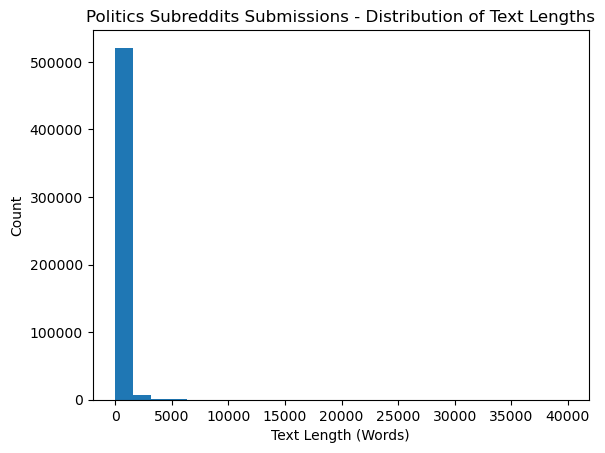

In [28]:
# Plot distribution of text lengths
plt.hist(pandas_df_pol_subs["text_length"], bins=25)
plt.xlabel("Text Length (Words)")
plt.ylabel("Count")
plt.title("Politics Subreddits Submissions - Distribution of Text Lengths")
plt.savefig("../../data/plots/text_length_pol_subs.png")
plt.show()

## Distribution of text lengths of economics subreddits submissions body

In [30]:
# Calculate text lengths
text_lengths = submissions_cleaned.filter(F.col("subreddit").isin(excluded_subreddits))\
                                           .select(F.length("selftext").alias("text_length"))

# Convert Spark dataframe to Pandas dataframe
pandas_df_econ_subs = text_lengths.toPandas()

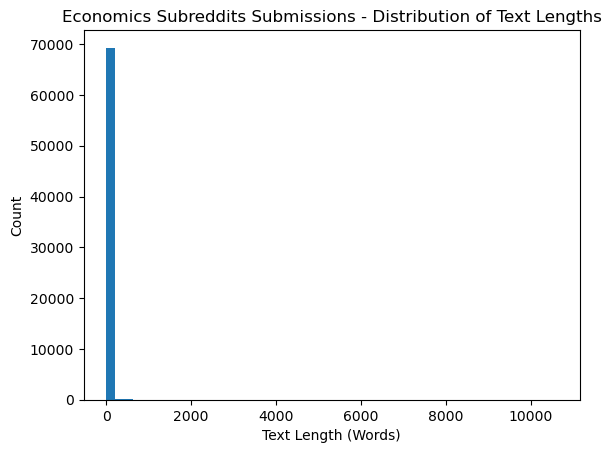

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:458)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)


In [31]:
# Plot distribution of text lengths
plt.hist(pandas_df_econ_subs["text_length"], bins=50)
plt.xlabel("Text Length (Words)")
plt.ylabel("Count")
plt.title("Economics Subreddits Submissions - Distribution of Text Lengths")
plt.savefig("../../data/plots/text_length_econ_subs.png")
plt.show()

## Distribution of text lengths of politics subreddits comments body

In [16]:
excluded_subreddits = ["Economics", "finance"]

# Calculate text lengths
text_lengths = submissions_cleaned.filter(~F.col("subreddit").isin(excluded_subreddits))\
                                            .select(F.length("selftext").alias("text_length"))

# Convert Spark dataframe to Pandas dataframe
pandas_df_pol_comms = text_lengths.toPandas()

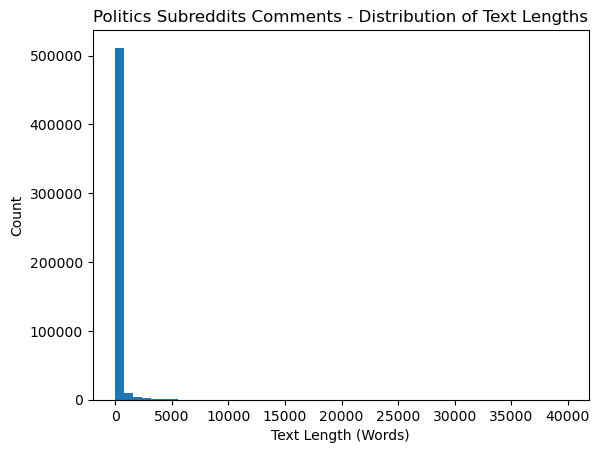

In [20]:
import matplotlib.pyplot as plt
# Plot distribution of text lengths
plt.hist(pandas_df_pol_comms["text_length"], bins=50)
plt.xlabel("Text Length (Words)")
plt.ylabel("Count")
plt.title("Politics Subreddits Comments - Distribution of Text Lengths")
plt.savefig("../../data/plots/text_length_pol_comms.png")
plt.show()

## Distribution of text lengths of economics subreddits comments body

In [18]:
excluded_subreddits = ["Economics", "finance"]

# Calculate text lengths
text_lengths = comments_cleaned.filter(F.col("subreddit").isin(excluded_subreddits))\
                                         .select(F.length("body").alias("text_length"))

# Convert Spark dataframe to Pandas dataframe
pandas_df_econ_comms = text_lengths.toPandas()

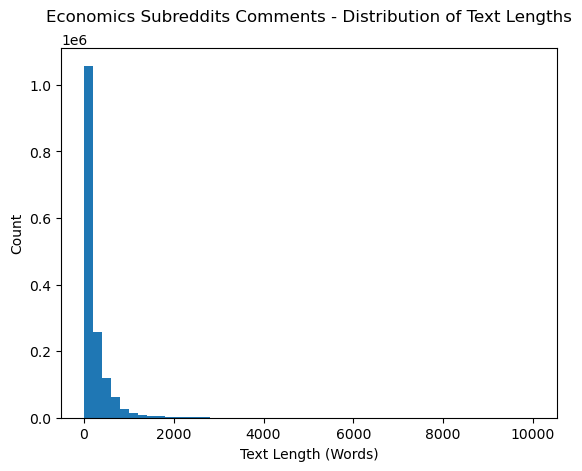

In [19]:
# Plot distribution of text lengths
plt.hist(pandas_df_econ_comms["text_length"], bins=50)
plt.xlabel("Text Length (Words)")
plt.ylabel("Count")
plt.title("Economics Subreddits Comments - Distribution of Text Lengths", y=1.05)
plt.savefig("../../data/plots/text_length_econ_comms.png")
plt.show()

## Variation in text length over time

In [11]:
excluded_subreddits = ["Economics", "finance"]

# filter for subreddits + reformat date
econ_subs_body_title_words = submissions_cleaned.filter(F.col("subreddit").isin(excluded_subreddits))\
                                                .withColumn('created_utc', F.date_format('created_utc', 'yyyy-MM-dd'))
pol_subs_body_title_words = submissions_cleaned.filter(~F.col("subreddit").isin(excluded_subreddits))\
                                                .withColumn('created_utc', F.date_format('created_utc', 'yyyy-MM-dd'))
pol_comms_body_words = comments_cleaned.filter(~F.col("subreddit").isin(excluded_subreddits))\
                                                .withColumn('created_utc', F.date_format('created_utc', 'yyyy-MM-dd'))
econ_comms_body_words = comments_cleaned.filter(F.col("subreddit").isin(excluded_subreddits))\
                                                .withColumn('created_utc', F.date_format('created_utc', 'yyyy-MM-dd'))

# create year + month cols
econ_subs_body_title_words = econ_subs_body_title_words.withColumn('year', F.year('created_utc')).withColumn('month', F.month('created_utc'))
pol_subs_body_title_words = pol_subs_body_title_words.withColumn('year', F.year('created_utc')).withColumn('month', F.month('created_utc'))
pol_comms_body_words = pol_comms_body_words.withColumn('year', F.year('created_utc')).withColumn('month', F.month('created_utc'))
econ_comms_body_words = econ_comms_body_words.withColumn('year', F.year('created_utc')).withColumn('month', F.month('created_utc'))

In [12]:
# Add a column for wordcount
econ_subs_body_title_words = econ_subs_body_title_words.withColumn('word_count', F.size(F.split('selftext', ' ')))
pol_subs_body_title_words = pol_subs_body_title_words.withColumn('word_count', F.size(F.split('selftext', ' ')))
pol_comms_body_words = pol_comms_body_words.withColumn('word_count', F.size(F.split('body', ' ')))
econ_comms_body_words = econ_comms_body_words.withColumn('word_count', F.size(F.split('body', ' ')))

In [13]:
# Grouping by month and year of the date_column
econ_subs_wordcount_grouped = econ_subs_body_title_words.groupBy("year", "month").agg(F.avg("word_count").alias("avg_count"))

# Sorting the DataFrame by year and month
econ_subs_wordcount_grouped = econ_subs_wordcount_grouped.sort(F.asc("year"), F.asc("month"))

# Grouping by month and year of the date_column
pol_subs_wordcount_grouped = pol_subs_body_title_words.groupBy("year", "month").agg(F.avg("word_count").alias("avg_count"))

# Sorting the DataFrame by year and month
pol_subs_wordcount_grouped = pol_subs_wordcount_grouped.sort(F.asc("year"), F.asc("month"))

# Grouping by month and year of the date_column
pol_comms_wordcount_grouped = pol_comms_body_words.groupBy("year", "month").agg(F.avg("word_count").alias("avg_count"))

# Sorting the DataFrame by year and month
pol_comms_wordcount_grouped = pol_comms_wordcount_grouped.sort(F.asc("year"), F.asc("month"))

# Grouping by month and year of the date_column
econ_comms_wordcount_grouped = econ_comms_body_words.groupBy("year", "month").agg(F.avg("word_count").alias("avg_count"))

# Sorting the DataFrame by year and month
econ_comms_wordcount_grouped = econ_comms_wordcount_grouped.sort(F.asc("year"), F.asc("month"))

# Converting Spark DataFrames to Pandas DataFrames
econ_subs_wordcount_grouped = econ_subs_wordcount_grouped.toPandas()
pol_subs_wordcount_grouped = pol_subs_wordcount_grouped.toPandas()
pol_comms_wordcount_grouped = pol_comms_wordcount_grouped.toPandas()
econ_comms_wordcount_grouped = econ_comms_wordcount_grouped.toPandas()

# Add subreddit+post column

econ_subs_wordcount_grouped['type'] = 'Economics Subreddits Submissions'
pol_subs_wordcount_grouped['type'] = 'Politics Subreddits Submissions'
pol_comms_wordcount_grouped['type'] = 'Politics Subreddits Comments'
econ_comms_wordcount_grouped['type'] = 'Economics Subreddits Comments'

# Outputting Pandas DataFrames to CSV files
# econ_subs_wordcount_grouped.to_csv("../data/csv/wordcount_econ_subs.csv", index=False)
# pol_subs_wordcount_grouped.to_csv("../data/csv/wordcount_pol_subs.csv", index=False)
# pol_comms_wordcount_grouped.to_csv("../data/csv/wordcount_pol_comms.csv", index=False)
# econ_comms_wordcount_grouped.to_csv("../data/csv/wordcount_econ_comms.csv", index=False)

In [14]:
df_textlength = pd.concat([econ_subs_wordcount_grouped, pol_subs_wordcount_grouped, pol_comms_wordcount_grouped, econ_comms_wordcount_grouped], ignore_index=True)

df_textlength[['month', 'year']] = df_textlength[['month', 'year']].astype(str)
df_textlength['month_year'] = df_textlength.apply(lambda x: pd.to_datetime(x['month'] + ' ' + x['year'], format='%m %Y').strftime('%b %Y'), axis=1)
df_textlength = df_textlength[['month_year','avg_count','type']]
df_textlength['avg_count'] = df_textlength['avg_count'].round(2)

# Outputting Appended Pandas DataFrames to CSV files
#df_textlength.to_csv("../../data/csv/wordcount_all.csv", index=False)

/tmp/ipykernel_18/491877651.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_textlength['month_year'], rotation=45)


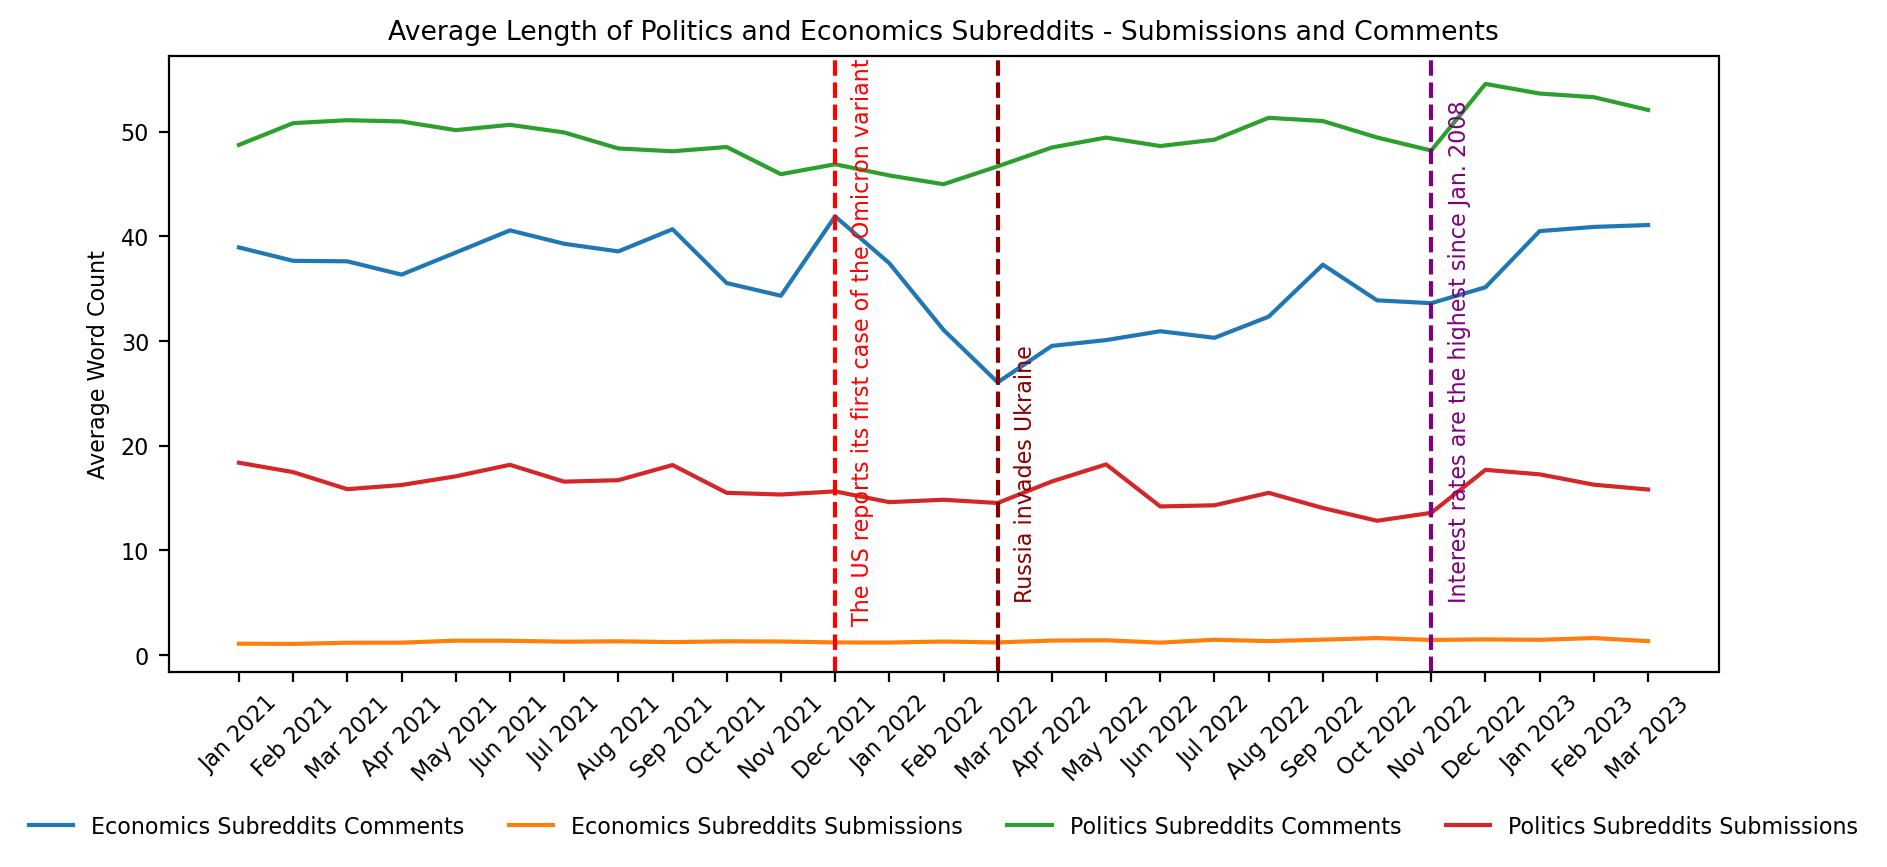

In [43]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5,7)
plt.rcParams["figure.dpi"] = 200

# Set font size
plt.rcParams.update({'font.size': 8})

# Create plot
fig, ax = plt.subplots(figsize=(10, 4))
for name, group in df_textlength.groupby('type'):
    ax.plot(group['month_year'], group['avg_count'], label=name)

# Set labels and title
ax.set_xlabel(None)
ax.set_ylabel('Average Word Count')
ax.set_title('Average Length of Politics and Economics Subreddits - Submissions and Comments')

ax.set_xticklabels(df_textlength['month_year'], rotation=45)

# Set legend
legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=len(df_textlength['type'].unique()), fontsize=8, title=None)
# Remove the box around the legend
legend.get_frame().set_linewidth(0.0)
# Dec 2021 highlight
plt.axvline(x=11, color='red', ls='--')
ax.text(11.3, 3.3, "The US reports its first case of the Omicron variant", color='red', rotation=90)
# March 2022 highlight
plt.axvline(x=14, color='darkred', ls='--')
ax.text(14.3, 5.5, "Russia invades Ukraine", color='darkred', rotation=90)
# Nov 2022 highlight
plt.axvline(x=22, color='purple', ls='--')
ax.text(22.3, 5.5, "Interest rates are the highest since Jan. 2008", color='purple', rotation=90)
# Save plot
plt.savefig("../../data/plots/wordcount_over_time.png", bbox_inches='tight')
plt.savefig("../../website-source/plots/wordcount_over_time.png", bbox_inches='tight')
# Show plot
plt.show()

## LDA with gensim and pyLDAvis

### Politics Subreddits Submissions

In [15]:
!pip install gensim


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [16]:
!pip install pyLDAvis

  Using cached pyLDAvis-3.4.1-py3-none-any.whl (2.6 MB)
  Obtaining dependency information for pandas>=2.0.0 from https://files.pythonhosted.org/packages/1b/fa/4e5d054549faf1524230ffcd57ca98bb7350a4ed62ef722daabde4cb7632/pandas-2.1.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached pandas-2.1.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached funcy-2.0-py2.py3-none-any.whl (30 kB)
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)
Using cached pandas-2.1.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.4
    Uninstalling pandas-1.4.4:
      Successfully uninstalled pandas-1.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autovizwidget 0.21.0 requires pandas<2.0.0,>=0.20.1, but yo

In [17]:
#Gensim
import gensim
import gensim.corpora as corpora

#vis
import pyLDAvis
import pyLDAvis.gensim

/opt/conda/lib/python3.10/site-packages/sklearn/utils/multiclass.py:14: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:18: DeprecationWarning: Please use `line_search_wolfe2` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprecated.
  from scipy.optimize.linesearch import line_search_wolfe2, line_search_wolfe1
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:18: DeprecationWarning: Please use `line_search_wolfe1` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprecated.
  from scipy.optimize.linesearch import line_search_wolfe2, line_search_wolfe1


In [21]:
excluded_subreddits = ["Economics", "finance"]

# Concat body, title and filter for political subreddits
pol_subs_body_title_words = submissions_cleaned.filter(~F.col("subreddit").isin(excluded_subreddits))\
                                               .select(F.concat_ws(" ", submissions_cleaned.cleaned_title,submissions_cleaned.cleaned_body)\
                                               .alias("nlpbodytext"))

# Function to tokenize a text into a list of words
def tokenize_text(text):
    return text.split()

# Define a UDF to tokenize the text
tokenize_udf = F.udf(tokenize_text, ArrayType(StringType()))

# Apply the UDF to tokenize the text and create a new column
pol_subs_body_title_words = pol_subs_body_title_words.withColumn('tokenized_text', tokenize_udf(pol_subs_body_title_words['nlpbodytext']))

# Collect the tokenized text as a list of lists
texts = [row['tokenized_text'] for row in pol_subs_body_title_words.select('tokenized_text').collect()]

# Create the Gensim dictionary
id2word = corpora.Dictionary(texts)

# Create the corpus
corpus = [id2word.doc2bow(tokens) for tokens in texts]

print(corpus[0][0:20])

print(id2word[[0][:1][0]])

[(0, 2), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)]
actually


In [22]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

In [24]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds="mmds", R=30, n_jobs=1)
vis

/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  with warnings.catch_warnings():


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.138705  0.366667       1        1  32.301397
0     -0.129492 -0.377496       2        1  26.090817
3     -0.403062 -0.003586       3        1  22.830628
2      0.325609 -0.232562       4        1  12.002492
4      0.345650  0.246976       5        1   6.774665, topic_info=         Term           Freq          Total Category  logprob  loglift
182    remove  128211.000000  128211.000000  Default  30.0000  30.0000
88     delete   85589.000000   85589.000000  Default  29.0000  29.0000
90     people   76038.000000   76038.000000  Default  28.0000  28.0000
2386    widen   55297.000000   55297.000000  Default  27.0000  27.0000
48       like   44169.000000   44169.000000  Default  26.0000  26.0000
...       ...            ...            ...      ...      ...      ...
206     admit    3313.992029    3314.896323   Topic5  -5.1557   2.6917
2971  message    3279.082882    3279.986967   Topic5  -5.1663   2.6917
143      link    3265.947393    3266.850315   Topic5  -5.1703   2.6917
525      read    5960.470119    7337.739164   Topic5  -4.5687   2.4841
46      leave    3718.743743   18575.998934   Topic5  -5.0405   1.0835

[208 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
539       4  0.999879     abortion
206       5  0.999730        admit
1524      5  0.999753  afghanistan
737       3  0.999886        allow
840       1  0.999967         also
...     ...       ...          ...
454       5  0.999823         wing
680       3  0.999880      without
307       3  0.999976         work
505       1  0.999900        world
121       3  0.999952         year

[197 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 3, 5])

In [25]:
pyLDAvis.save_html(vis, '../../data/plots/pol_subs_lda.html')

### Economics Subreddits Submissions

In [30]:
excluded_subreddits = ["Economics", "finance"]

# Concat body, title and filter for political subreddits
econ_subs_body_title_words = submissions_cleaned.filter(F.col("subreddit").isin(excluded_subreddits))\
                                               .select(F.concat_ws(" ", submissions_cleaned.cleaned_title,submissions_cleaned.cleaned_body)\
                                               .alias("nlpbodytext"))

substr_to_remove = ["http", "https", "tinyurl", "com", "www", "jpg", "uploads", "delete", "remove", ]
regex = "|".join(substr_to_remove)
econ_subs_body_title_words = econ_subs_body_title_words.withColumn("nlpbodytext", F.regexp_replace("nlpbodytext", regex, " "))

# Function to tokenize a text into a list of words
def tokenize_text(text):
    return text.split()

# Define a UDF to tokenize the text
tokenize_udf = F.udf(tokenize_text, ArrayType(StringType()))

# Apply the UDF to tokenize the text and create a new column
econ_subs_body_title_words = econ_subs_body_title_words.withColumn('tokenized_text', tokenize_udf(econ_subs_body_title_words['nlpbodytext']))

# Collect the tokenized text as a list of lists
texts = [row['tokenized_text'] for row in econ_subs_body_title_words.select('tokenized_text').collect()]

# Create the Gensim dictionary
id2word = corpora.Dictionary(texts)

# Create the corpus
corpus = [id2word.doc2bow(tokens) for tokens in texts]

print(corpus[0][0:20])

print(id2word[[0][:1][0]])

[(0, 1)]
shubham


In [31]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

In [32]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds="mmds", R=30, n_jobs=1)
vis

/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  with warnings.catch_warnings():


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.245310  0.280956       1        1  23.853449
4     -0.031705 -0.372310       2        1  20.220195
3     -0.367307 -0.095180       3        1  19.973650
1     -0.201364  0.332963       4        1  18.382743
2      0.355066 -0.146429       5        1  17.569963, topic_info=                 Term         Freq        Total Category  logprob  loglift
711                 s  7965.000000  7965.000000  Default  30.0000  30.0000
707   fintechinshorts  7193.000000  7193.000000  Default  29.0000  29.0000
706           content  3619.000000  3619.000000  Default  28.0000  28.0000
708       fintechnews  3606.000000  3606.000000  Default  27.0000  27.0000
713                wp  3575.000000  3575.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
527             asset   551.762304   552.598500   Topic5  -5.2732   1.7375
1057              app   535.341109   536.169764   Topic5  -5.3034   1.7374
916                 r   495.480892   496.295343   Topic5  -5.3808   1.7373
1042            right   452.700533   453.537992   Topic5  -5.4711   1.7371
37               bank  1567.351623  3612.686967   Topic5  -4.2292   0.9039

[187 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
593       5  0.999297   account
424       2  0.999284    action
510       2  0.999182  american
871       2  0.999179       amp
705       5  0.999160  announce
...     ...       ...       ...
491       2  0.998303    worker
47        1  0.999462     world
713       5  0.999695        wp
1497      4  0.998805  xinjiang
116       3  0.999457      year

[160 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 2, 3])

In [33]:
pyLDAvis.save_html(vis, '../../data/plots/econ_subs_lda.html')

## LDA for Shared Users Across Political Subreddits

In [18]:
# Calculate the number of unique subreddits per author
author_subreddit_count = submissions_cleaned.groupBy("author").agg(F.countDistinct("subreddit").alias("subreddit_count"))

# Filter authors with more than 2 subreddits
filtered_authors = author_subreddit_count.filter("subreddit_count > 2").select("author")

# Join the original DataFrame with the filtered authors
submissions_cleaned_common_users = submissions_cleaned.join(filtered_authors, "author", "inner")

In [19]:
excluded_subreddits = ["Economics", "finance"]

# Concat body, title and filter for political subreddits
pol_subs_body_title_words_common_users = submissions_cleaned_common_users.filter(~F.col("subreddit").isin(excluded_subreddits))\
                                               .select(F.concat_ws(" ", submissions_cleaned_common_users.cleaned_title,submissions_cleaned_common_users.cleaned_body)\
                                               .alias("nlpbodytext"))

substr_to_remove = ["http", "https", "tinyurl", "com", "www", "jpg", "uploads", "delete", "remove"]
regex = "|".join(substr_to_remove)
pol_subs_body_title_words_common_users = pol_subs_body_title_words_common_users.withColumn("nlpbodytext", F.regexp_replace("nlpbodytext", regex, " "))

# Function to tokenize a text into a list of words
def tokenize_text(text):
    return text.split()

# Define a UDF to tokenize the text
tokenize_udf = F.udf(tokenize_text, ArrayType(StringType()))

# Apply the UDF to tokenize the text and create a new column
pol_subs_body_title_words_common_users = pol_subs_body_title_words_common_users.withColumn('tokenized_text', tokenize_udf(pol_subs_body_title_words_common_users['nlpbodytext']))

# Collect the tokenized text as a list of lists
texts = [row['tokenized_text'] for row in pol_subs_body_title_words_common_users.select('tokenized_text').collect()]

# Create the Gensim dictionary
id2word = corpora.Dictionary(texts)

# Create the corpus
corpus = [id2word.doc2bow(tokens) for tokens in texts]

print(corpus[0][0:20])

print(id2word[[0][:1][0]])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]
copy


In [20]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

In [21]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds="mmds", R=30, n_jobs=1)
vis

/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  with warnings.catch_warnings():


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.416248 -0.027873       1        1  32.232283
2      0.148737  0.358904       2        1  25.370988
4     -0.343727 -0.212737       3        1  16.118455
3     -0.308108  0.265578       4        1  15.282869
0      0.086850 -0.383872       5        1  10.995405, topic_info=          Term          Freq         Total Category  logprob  loglift
46       widen  11670.000000  11670.000000  Default  30.0000  30.0000
9          new   6258.000000   6258.000000  Default  29.0000  29.0000
249      trump   9576.000000   9576.000000  Default  28.0000  28.0000
233     people  11373.000000  11373.000000  Default  27.0000  27.0000
405      right   5331.000000   5331.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
4416        gt    962.749257    963.363461   Topic5  -5.1680   2.2071
3056      musk    928.243350    928.842696   Topic5  -5.2045   2.2070
1772    oppose    938.527002    939.145760   Topic5  -5.1935   2.2070
3392  property    942.550769    943.172858   Topic5  -5.1892   2.2070
2683     major    921.802598    922.415351   Topic5  -5.2114   2.2070

[183 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1606      4  0.999468   abortion
678       1  0.999926       also
6         2  0.999684    america
1810      1  0.999755   american
761       2  0.999895  americana
...     ...       ...        ...
46        2  0.999922      widen
117       2  0.999918        win
429       1  0.999969       work
734       3  0.999666      world
319       1  0.999786       year

[156 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 5, 4, 1])

In [22]:
pyLDAvis.save_html(vis, '../../data/plots/lda_shared_users_subs.html')